# T81-558: Applications of Deep Neural Networks
**Module 6: Convolutional Neural Networks (CNN) for Computer Vision**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module Video Material

Main video lecture:

* [Part 6.1: Image Processing in Python](https://www.youtube.com/watch?v=Oe0-hX4KSZQ&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN&index=18)
* [Part 6.2: Keras Neural Networks for Digits and Fashion MINST](https://www.youtube.com/watch?v=GDlI-3O5r6I&index=19&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 6.3: Implementing a ResNet in Keras](https://www.youtube.com/watch?v=zUZRUTJbYm8&index=20&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 6.4: Computer Vision with OpenCV](https://www.youtube.com/watch?v=zUZRUTJbYm8&index=20&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 6.5: Recognizing Multiple Images with Darknet](https://www.youtube.com/watch?v=zUZRUTJbYm8&index=20&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)

# Part 6.1: Image Processing in Python

We will make use of images to demonstrate auto encoders.  To use images in Python, we will make use of the Pillow package.  This package can be installed with the following command.  

```
pip install pillow
```

The following program uses Pillow to load and display an image.

In [ ]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

print(np.asarray(img))

img

### Creating Images (from pixels) in Python

Pillow can also be used to create an image from a 3D numpy cube.  The rows and columns specify the pixels.  The depth, of 3, specifies red, green and blue.  Here a simple image is created.

In [ ]:
from PIL import Image
import numpy as np

w, h = 64, 64
data = np.zeros((h, w, 3), dtype=np.uint8)

# Yellow
for row in range(32):
    for col in range(32):
        data[row,col] = [255,255,0]
        
# Red
for row in range(32):
    for col in range(32):
        data[row+32,col] = [255,0,0]
        
# Green
for row in range(32):
    for col in range(32):
        data[row+32,col+32] = [0,255,0]        
        
# Blue
for row in range(32):
    for col in range(32):
        data[row,col+32] = [0,0,255]                
        

img = Image.fromarray(data, 'RGB')
img

### Transform Images in Python (at the pixel level)

We can combine the last two programs and modify images.  Here we take the mean color of each pixel and form a grayscale image.

In [ ]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"
#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image
img2_array = np.zeros((rows, cols, 3), dtype=np.uint8)
for row in range(rows):
    for col in range(cols):
        t = np.mean(img_array[row,col])
        img2_array[row,col] = [t,t,t]

img2 = Image.fromarray(img2_array, 'RGB')
img2  

# Standardize Images

When processing several images together it is sometimes important to standardize them.  The following code reads a sequence of images and causes them to all be of the same size and perfectly square.  If the input images are not square, cropping will occur.

In [ ]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML

#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

images = [
    "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG",
    "https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg"    
]


def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img
    
x = [] 
    
for url in images:
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = make_square(img)
    img = img.resize((128,128), Image.ANTIALIAS)
    print(url)
    display(img)
    img_array = np.asarray(img)
    img_array = img_array.flatten()
    img_array = img_array.astype(np.float32)
    img_array = (img_array-128)/128
    x.append(img_array)
    

x = np.array(x)

print(x.shape)


### Adding Noise to an Image

Auto encoders can handle noise.  First it is important to see how to add noise to an image.  There are many ways to add such noise.  The following code adds random black squares to the image to produce noise.

In [ ]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline


def add_noise(a):
    a2 = a.copy()
    rows = a2.shape[0]
    cols = a2.shape[1]
    s = int(min(rows,cols)/20) # size of spot is 1/20 of smallest dimension
    
    for i in range(100):
        x = np.random.randint(cols-s)
        y = np.random.randint(rows-s)
        a2[y:(y+s),x:(x+s)] = 0
        
    return a2

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"
#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image
img2_array = img_array.astype(np.uint8)
print(img2_array.shape)
img2_array = add_noise(img2_array)
img2 = Image.fromarray(img2_array, 'RGB')
img2        
        

# Part 6.2: Keras Neural Networks for Digits and Fashion MINST

# Computer Vision

This class will focus on computer vision.  There are some important differences and similarities with previous neural networks.

* We will usually use classification, though regression is still an option.
* The input to the neural network is now 3D (height, width, color)
* Data are not transformed, no z-scores or dummy variables.
* Processing time is much longer.
* We now have different layer times: dense layers (just like before), convolution layers and max pooling layers.
* Data will no longer arrive as CSV files. TensorFlow provides some utilities for going directly from image to the input for a neural network.


# Computer Vision Data Sets

There are many data sets for computer vision.  Two of the most popular are the MNIST digits data set and the CIFAR image data sets.

## MNIST Digits Data Set

The [MNIST Digits Data Set](http://yann.lecun.com/exdb/mnist/) is very popular in the neural network research community.  A sample of it can be seen here:

![MNIST Data Set](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_mnist.png "MNIST Data Set")

This data set was generated from scanned forms.

![Exam](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_exam.png "Exam")


## CIFAR Data Set

The [CIFAR-10 and CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) datasets are also frequently used by the neural network research community.

![cifar-10](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_cifar.png "cifar-10")

The CIFAR-10 data set contains low-rez images that are divided into 10 classes.  The CIFAR-100 data set contains 100 classes in a hierarchy. 

# Other Resources

* [Imagenet:Large Scale Visual Recognition Challenge 2014](http://image-net.org/challenges/LSVRC/2014/index)
* [Andrej Karpathy](http://cs.stanford.edu/people/karpathy/) - PhD student/instructor at Stanford.
    * [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/) - Stanford course on computer vision/CNN's.
        * [CS231n - GitHub](http://cs231n.github.io/)
    * [ConvNetJS](http://cs.stanford.edu/people/karpathy/convnetjs/) - JavaScript library for deep learning.
 

# Convolutional Neural Networks (CNNs)

The convolutional neural network (CNN) is a neural network technology that has profoundly impacted the area of computer vision (CV). Fukushima (1980) introduced the original concept of a convolutional neural network, and LeCun, Bottou, Bengio & Haffner (1998) greatly improved this work. From this research, Yan LeCun introduced the famous LeNet-5 neural network architecture. This class follows the LeNet-5 style of convolutional neural network.

**A LeNET-5 Network (LeCun, 1998)**
![LENET5](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_lenet5.png "LENET5")

So far we have only seen one layer type (dense layers).  By the end of this course we will have seen:

* **Dense Layers** - Fully connected layers.  (introduced previously)
* **Convolution Layers** - Used to scan across images. (introduced this class)
* **Max Pooling Layers** - Used to downsample images. (introduced this class)
* **Dropout Layer** - Used to add regularization. (introduced next class)

## Convolution Layers

The first layer that we will examine is the convolutional layer. We will begin by looking at the hyper-parameters that you must specify for a convolutional layer in most neural network frameworks that support the CNN:

* Number of filters
* Filter Size
* Stride
* Padding
* Activation Function/Non-Linearity

The primary purpose for a convolutional layer is to detect features such as edges, lines, blobs of color, and other visual elements. The filters can detect these features. The more filters that we give to a convolutional layer, the more features it can detect.

A filter is a square-shaped object that scans over the image. A grid can represent the individual pixels of a grid. You can think of the convolutional layer as a smaller grid that sweeps left to right over each row of the image. There is also a hyper parameter that specifies both the width and height of the square-shaped filter. Figure 10.1 shows this configuration in which you see the six convolutional filters sweeping over the image grid:

A convolutional layer has weights between it and the previous layer or image grid. Each pixel on each convolutional layer is a weight. Therefore, the number of weights between a convolutional layer and its predecessor layer or image field is the following:

```
[FilterSize] * [FilterSize] * [# of Filters]
```

For example, if the filter size were 5 (5x4) for 10 filters, there would be 250 weights.

You need to understand how the convolutional filters sweep across the previous layer’s output or image grid. Figure 10.2 illustrates the sweep:

![CNN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_cnn_grid.png "CNN")

The above figure shows a convolutional filter with a size of 4 and a padding size of 1. The padding size is responsible for the boarder of zeros in the area that the filter sweeps. Even though the image is actually 8x7, the extra padding provides a virtual image size of 9x8 for the filter to sweep across. The stride specifies the number of positions at which the convolutional filters will stop. The convolutional filters move to the right, advancing by the number of cells specified in the stride. Once the far right is reached, the convolutional filter moves back to the far left, then it moves down by the stride amount and
continues to the right again.

Some constraints exist in relation to the size of the stride. Obviously, the stride cannot be 0. The convolutional filter would never move if the stride were set to 0. Furthermore, neither the stride, nor the convolutional filter size can be larger than the previous grid. There are additional constraints on the stride (s), padding (p) and the filter width (f) for an image of width (w). Specifically, the convolutional filter must be able to start at the far left or top boarder, move a certain number of strides, and land on the far right or bottom boarder. The following equation shows the number of steps a convolutional operator
must take to cross the image:

$ steps = \frac{w - f + 2p}{s+1} $

The number of steps must be an integer. In other words, it cannot have decimal places. The purpose of the padding (p) is to be adjusted to make this equation become an integer value.

## Max Pooling Layers

Max-pool layers downsample a 3D box to a new one with smaller dimensions. Typically, you can always place a max-pool layer immediately following convolutional layer. The LENET shows the max-pool layer immediately after layers C1 and C3. These max-pool layers progressively decrease the size of the dimensions of the 3D boxes passing through them. This technique can avoid overfitting (Krizhevsky, Sutskever & Hinton, 2012).

A pooling layer has the following hyper-parameters:

* Spatial Extent (f )
* Stride (s)

Unlike convolutional layers, max-pool layers do not use padding. Additionally, max-pool layers have no weights, so training does not affect them. These layers simply downsample their 3D box input. The 3D box output by a max-pool layer will have a width equal to this equation:

$ w_2 = \frac{w_1 - f}{s + 1} $

The height of the 3D box produced by the max-pool layer is calculated similarly with this equation:

$ h_2 = \frac{h_1 - f}{s + 1} $

The depth of the 3D box produced by the max-pool layer is equal to the depth the 3D box received as input. The most common setting for the hyper-parameters of a max-pool layer are f =2 and s=2. The spatial extent (f) specifies that boxes of 2x2 will be scaled down to single pixels. Of these four pixels, the pixel with the maximum value will represent the 2x2 pixel in the new grid. Because squares of size 4 are replaced with size 1, 75% of the pixel information is lost. The following figure shows this transformation as a 6x6 grid becomes a 3x3:

![MaxPool](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_conv_maxpool.png "MaxPool")

Of course, the above diagram shows each pixel as a single number. A grayscale image would have this characteristic. For an RGB image, we usually take the average of the three numbers to determine which pixel has the maximum value.

[More information on CNN's](http://cs231n.github.io/convolutional-networks/)

# TensorFlow with CNNs

The following sections describe how to use TensorFlow/Keras with CNNs.

### Access to Data Sets - DIGITS

Keras provides built in access classes for MNIST.  It is important to note that MNIST data arrives already separated into two sets:

* **train** - Neural network will be trained with this.
* **test** - Used for validation.

In [ ]:
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

### Display the Digits 

The following code shows what the MNIST files contain.

In [ ]:
# Display as text
from IPython.display import display
import pandas as pd

print("Shape for dataset: {}".format(x_train.shape))
print("Labels: {}".format(y_train))

# Single MNIST digit
single = x_train[0]
print("Shape for single: {}".format(single.shape))

display(pd.DataFrame(single.reshape(28,28)))

In [ ]:
# Display as image
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
digit = 105 # Change to choose new digit
a = x_train[digit]
plt.imshow(a, cmap='gray', interpolation='nearest')
print("Image (#{}): Which is digit '{}'".format(digit,y_train[digit]))

In [ ]:
import random

ROWS = 6
random_indices = random.sample(range(x_train.shape[0]), ROWS*ROWS)

sample_images = x_train[random_indices, :]

plt.clf()

fig, axes = plt.subplots(ROWS,ROWS, 
                         figsize=(ROWS,ROWS),
                         sharex=True, sharey=True) 

for i in range(ROWS*ROWS):
    subplot_row = i//ROWS 
    subplot_col = i%ROWS
    ax = axes[subplot_row, subplot_col]

    plottable_image = np.reshape(sample_images[i,:], (28,28))
    ax.imshow(plottable_image, cmap='gray_r')
    
    ax.set_xbound([0,28])

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
batch_size = 128
num_classes = 10
epochs = 12
# input image dimensions
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))
# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])


### Training/Fitting CNN - DIGITS

The following code will train the CNN for 20,000 steps.  This can take awhile, you might want to scale the step count back. GPU training can help.  My results:

* CPU Training Time: Elapsed time: 1:50:13.10
* GPU Training Time: Elapsed time: 0:13:43.06

In [ ]:
import tensorflow as tf
import time

start_time = time.time()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

### Evaluate Accuracy - DIGITS

Note, if you are using a GPU you might get the **ResourceExhaustedError**.  This occurs because the GPU might not have enough ram to predict the entire data set at once.  

In [ ]:
# Predict using either GPU or CPU, send the entire dataset.  This might not work on the GPU.
# Set the desired TensorFlow output level for this example
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

GPUs are most often used for training rather than prediction.  For prediction either disable the GPU or just predict on a smaller sample.  If your GPU has enough memory, the above prediction code may work just fine.  If not, just prediction on a sample with the following code:

In [ ]:
from sklearn import metrics

# For GPU just grab the first 100 images
small_x = x_test[1:100]
small_y = y_test[1:100]
small_y2 = np.argmax(small_y,axis=1)
pred = model.predict(small_x)
pred = np.argmax(pred,axis=1)
score = metrics.accuracy_score(small_y2, pred)
print('Accuracy: {}'.format(score))

### MINST Fashion

In [ ]:
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

### Display the Apparel 

The following code shows what the Fashion MNIST files contain.

In [ ]:
# Display as text
from IPython.display import display
import pandas as pd

print("Shape for dataset: {}".format(x_train.shape))
print("Labels: {}".format(y_train))

# Single MNIST digit
single = x_train[0]
print("Shape for single: {}".format(single.shape))

display(pd.DataFrame(single.reshape(28,28)))

In [ ]:
# Display as image
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
digit = 90 # Change to choose new article
a = x_train[digit]
plt.imshow(a, cmap='gray', interpolation='nearest')
print("Image (#{}): Which is digit '{}'".format(digit,y_train[digit]))

In [ ]:
import random

ROWS = 6
random_indices = random.sample(range(x_train.shape[0]), ROWS*ROWS)

sample_images = x_train[random_indices, :]

plt.clf()

fig, axes = plt.subplots(ROWS,ROWS, 
                         figsize=(ROWS,ROWS),
                         sharex=True, sharey=True) 

for i in range(ROWS*ROWS):
    subplot_row = i//ROWS 
    subplot_col = i%ROWS
    ax = axes[subplot_row, subplot_col]

    plottable_image = np.reshape(sample_images[i,:], (28,28))
    ax.imshow(plottable_image, cmap='gray_r')
    
    ax.set_xbound([0,28])

plt.tight_layout()
plt.show()


### Training/Fitting CNN - Fashion

The following code will train the CNN for 20,000 steps.  This can take awhile, you might want to scale the step count back. GPU training can help.  My results:

* CPU Training Time: Elapsed time: 1:50:13.10
* GPU Training Time: Elapsed time: 0:13:43.06

In [ ]:
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
batch_size = 128
num_classes = 10
epochs = 12
# input image dimensions
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))
# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])


In [ ]:
import tensorflow as tf
import time

start_time = time.time()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

# Part 6.3: Implementing a ResNet in Keras

Deeper neural networks are more difficult to train. Residual learning was introduced to ease the training of networks that are substantially deeper than those used previously. ResNet explicitly reformulates the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. On the ImageNet dataset this method was evaluated with residual nets with a depth of up to 152 layers---8x deeper than VGG nets but still having lower complexity. An ensemble of these residual nets achieves 3.57% error on the ImageNet test set. This result won the 1st place on the ILSVRC 2015 classification task. This technique can also be applied to the CIFAR-10 with 100 and 1000 layers. 

ResNet was introduced in the following paper:

* K. He, X. Zhang, S. Ren, and J. Sun. [Deep residual learning for image recognition](https://arxiv.org/abs/1512.03385). arXiv preprint arXiv:1512.03385,2015.

What is a residual?

* [Residual](https://www.merriam-webster.com/dictionary/residual): an internal aftereffect of experience or activity that influences later behavior

To implement a ResNet we need to give Keras the notion of a residual block.  This is essentially two dense layers with a "skip connection" (or residual connection).  A residual block is shown here.


![Skip Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/skip-layer.png "Skip Layers")

Residual blocks are typically used with convolutional neural networks (CNNs).  This allows very deep neural networks of CNNs to be created.  The following diagram shows several different ResNets.

![ResNet](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/resnet.png "ResNet")


### CIFAR Data Set

The [CIFAR-10 and CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) datasets are also frequently used by the neural network research community.  These datasets were originally part of a competition. 

![cifar-10](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_cifar.png "cifar-10")

The CIFAR-10 data set contains low-res images that are divided into 10 classes.  The CIFAR-100 data set contains 100 classes in a hierarchy. 


In [1]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Samples from the loaded CIFAR dataset can be displayed using the following code.

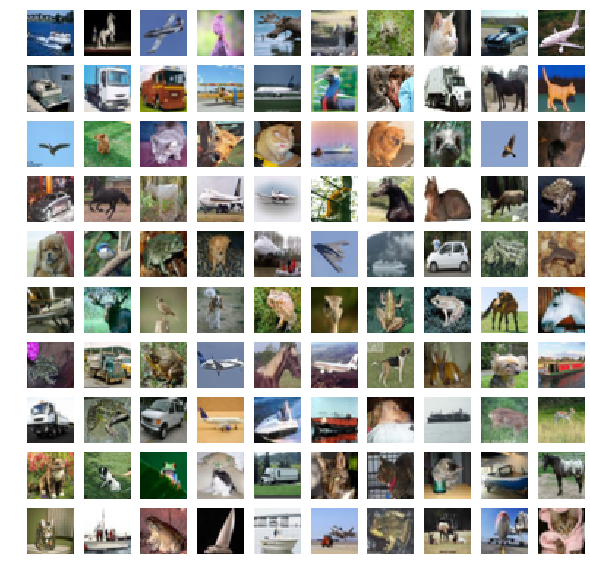

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle 

ROWS = 10

x = x_train.astype("uint8")

fig, axes1 = plt.subplots(ROWS,ROWS,figsize=(10,10))
for j in range(ROWS):
    for k in range(ROWS):
        i = np.random.choice(range(len(x)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x[i:i+1][0])

We will construct a ResNet and train it on the CIFAR-10 dataset.  The following block of code defines some constant values that define how the network is constructed.

In [3]:
# Training parameters
BATCH_SIZE = 32  # orig paper trained all networks with batch_size=128
EPOCHS = 200 # 200
USE_AUGMENTATION = True
NUM_CLASSES = np.unique(y_train).shape[0] # 10
COLORS = x_train.shape[3]

# Subtracting pixel mean improves accuracy
SUBTRACT_PIXEL_MEAN = True

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
VERSION = 1

# Computed depth from supplied model parameter n
if VERSION == 1:
    DEPTH = COLORS * 6 + 2
elif version == 2:
    DEPTH = COLORS * 9 + 2

The following function implements a learning rate decay schedule.

In [4]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

The following code implements a ResNet block.  This includes two convolutional layers with a skip connection.  Both V1 and V2 of ResNet make use of this type of layer.

In [5]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

### ResNet V1

* K. He, X. Zhang, S. Ren, and J. Sun. [Deep residual learning for image recognition](https://arxiv.org/abs/1512.03385). arXiv preprint arXiv:1512.03385,2015.

In [6]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

### ResNet V2

A second version of ResNet was introduced in the following paper.  This form of ResNet is commonly referred to as ResNet V2.

* He, K., Zhang, X., Ren, S., & Sun, J. (2016, October). [Identity mappings in deep residual networks](https://arxiv.org/abs/1603.05027). In European conference on computer vision (pp. 630-645). Springer, Cham.

The following code constructs a ResNet V2 network.  The primary difference of the full preactivation 'v2' variant compared to the 'v1' variant is the use of [batch normalization](https://arxiv.org/abs/1502.03167) before every weight layer.

In [7]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

With all of this defined, we can run the ResNet.

In [8]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if SUBTRACT_PIXEL_MEAN:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = tensorflow.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tensorflow.keras.utils.to_categorical(y_test, NUM_CLASSES)

# Create the neural network
if VERSION == 2:
    model = resnet_v2(input_shape=input_shape, depth=DEPTH)
else:
    model = resnet_v1(input_shape=input_shape, depth=DEPTH)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_n

In [10]:
import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not USE_AUGMENTATION:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                        validation_data=(x_test, y_test),
                        epochs=EPOCHS, verbose=0, workers=4,
                        callbacks=callbacks, use_multiprocessing=True)
    
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Using real-time data augmentation.
Learning rate:  0.001


Process ForkPoolWorker-10:
Process ForkPoolWorker-12:
Process ForkPoolWorker-9:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jheaton/miniconda3/envs/tensorflow-2.0/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/jheaton/miniconda3/envs/tensorflow-2.0/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jheaton/miniconda3/envs/tensorflow-2.0/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jheaton/miniconda3/envs/tensorflow-2.0/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/Users/jheaton/miniconda3/envs/tensorflow-2.0/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jheaton/mini

Learning rate:  0.001


  File "/Users/jheaton/miniconda3/envs/tensorflow-2.0/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Users/jheaton/miniconda3/envs/tensorflow-2.0/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/jheaton/miniconda3/envs/tensorflow-2.0/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: 

The trained neural network can now be evaluated.

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Part 6.4: Computer Vision with OpenCV

# Part 6.5: Recognizing Multiple Images with Darknet

# Module 6 Assignment

You can find the first assignment here: [assignment 6](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/assignments/assignment_yourname_class1.ipynb)